In [1]:
import numpy as np
import pandas as pd

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import pandas as pd

# Specify the file name you want to load
file_name = 'cleaned_dataset'

# S3 bucket and prefix
bucket = 'e-commerce-analysis'
prefix = 'merged_and_cleaned/'

# Full S3 path
s3_path = f's3://{bucket}/{prefix}{file_name}.csv'

# Load the file
try:
    df = pd.read_csv(s3_path)
    print(f" Successfully loaded: {file_name}")
except Exception as e:
    print(f" Failed to load {file_name}: {e}")


 Successfully loaded: cleaned_dataset


In [3]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,product_id,seller_id,shipping_limit_date,...,total_sales,delivery_delay_days,order_year,order_month,order_day,order_date,order_weekday,is_weekend,order_item_count,avg_price_per_item
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:00,2017-10-02 11:07:00,2017-10-04 19:55:00,2017-10-10 21:25:00,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:00,...,38.71,-8,2017,10,2,02-10-2017 10:56,0,0,3,9.996667
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:00,2017-10-02 11:07:00,2017-10-04 19:55:00,2017-10-10 21:25:00,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:00,...,38.71,-8,2017,10,2,02-10-2017 10:56,0,0,3,9.996667
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:00,2017-10-02 11:07:00,2017-10-04 19:55:00,2017-10-10 21:25:00,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:00,...,38.71,-8,2017,10,2,02-10-2017 10:56,0,0,3,9.996667
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:00,2017-08-15 20:05:00,2017-08-17 15:28:00,2017-08-18 14:44:00,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:00,...,37.77,-10,2017,8,15,15-08-2017 18:29,1,0,1,29.990000
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:00,2017-08-02 18:43:00,2017-08-04 17:35:00,2017-08-07 18:30:00,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:00,...,37.77,-8,2017,8,2,02-08-2017 18:24,2,0,1,29.990000


In [4]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

# ⏰ Strip to daily level using resample
daily_sales = df.resample('D', on='order_purchase_timestamp')['total_sales'].sum().reset_index()

# Continue with feature engineering
daily_sales['year'] = daily_sales['order_purchase_timestamp'].dt.year
daily_sales['month'] = daily_sales['order_purchase_timestamp'].dt.month
daily_sales['day'] = daily_sales['order_purchase_timestamp'].dt.day
daily_sales['dayofweek'] = daily_sales['order_purchase_timestamp'].dt.dayofweek
daily_sales['is_weekend'] = daily_sales['dayofweek'].isin([5, 6]).astype(int)

# Lag Features
daily_sales['lag_1'] = daily_sales['total_sales'].shift(1)
daily_sales['lag_7'] = daily_sales['total_sales'].shift(7)
daily_sales['lag_30'] = daily_sales['total_sales'].shift(30)

# Rolling Features
daily_sales['rolling_mean_7'] = daily_sales['total_sales'].rolling(7).mean()
daily_sales['rolling_std_7'] = daily_sales['total_sales'].rolling(7).std()
daily_sales['rolling_mean_30'] = daily_sales['total_sales'].rolling(30).mean()

# Differencing
daily_sales['sales_diff'] = daily_sales['total_sales'].diff()

# Drop NaNs from lag/rolling
daily_sales = daily_sales.dropna().reset_index(drop=True)


In [5]:
daily_sales.head()

,order_purchase_timestamp,total_sales,year,month,day,dayofweek,is_weekend,lag_1,lag_7,lag_30,rolling_mean_7,rolling_std_7,rolling_mean_30,sales_diff
0,2017-02-04,10529.7375,2017,2,4,5,1,6769.9325,5496.2425,2765.5400,8032.581429,2219.508201,4675.314083,3759.8050
1,2017-02-05,10035.4300,2017,2,5,6,1,10529.7375,4253.2800,708.7925,8858.602857,1555.067160,4986.202000,-494.3075
2,2017-02-06,9338.7925,2017,2,6,0,0,10035.4300,7203.5225,886.3550,9163.641429,1375.339633,5267.949917,-696.6375
3,2017-02-07,16248.3150,2017,2,7,1,0,9338.7925,10537.1675,347.2100,9979.519643,3027.534188,5797.986750,6909.5225
4,2017-02-08,12029.2375,2017,2,8,2,0,16248.3150,8236.9900,720.4575,10521.269286,3002.950343,6174.946083,-4219.0775


In [6]:
daily_sales.shape

(572, 14)

In [7]:
is_sorted = daily_sales['order_purchase_timestamp'].is_monotonic_increasing
print("Dates are sorted in ascending order." if is_sorted else "❌ Dates are NOT sorted.")

Dates are sorted in ascending order.


In [8]:
# Create a full daily date range from min to max
full_range = pd.date_range(
    start=daily_sales['order_purchase_timestamp'].min(),
    end=daily_sales['order_purchase_timestamp'].max()
)

# Compare with existing dates
missing_dates = full_range.difference(daily_sales['order_purchase_timestamp'])

if missing_dates.empty:
    print("No missing dates. Time series is continuous.")
else:
    print(f" Missing {len(missing_dates)} dates:")
    print(missing_dates)


No missing dates. Time series is continuous.


In [9]:
daily_sales.shape

(572, 14)

# ARIMA

## Step 1: Make Series Stationary

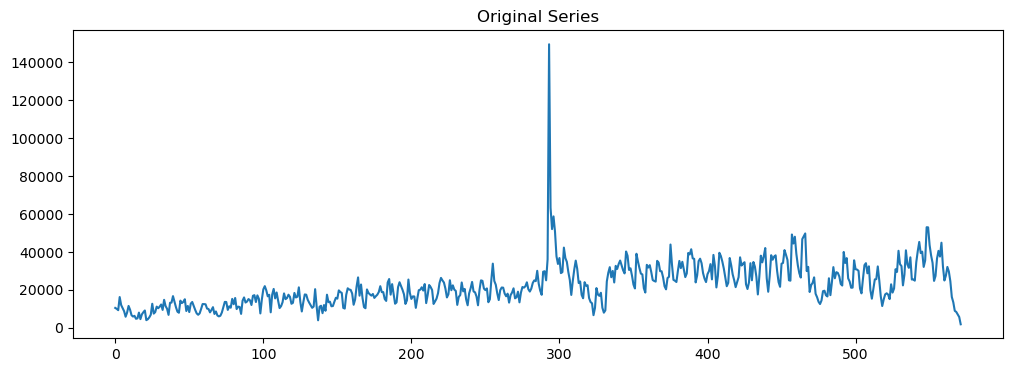

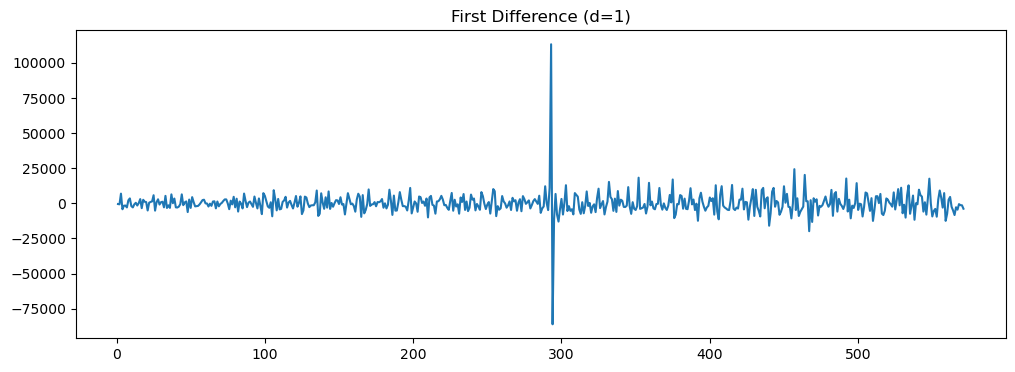

In [10]:
import matplotlib.pyplot as plt

# Plot original
daily_sales['total_sales'].plot(title='Original Series', figsize=(12, 4))
plt.show()

# First difference
df_diff = daily_sales['total_sales'].diff().dropna()
df_diff.plot(title='First Difference (d=1)', figsize=(12, 4))
plt.show()


## Step 2: Plot ACF and PACF

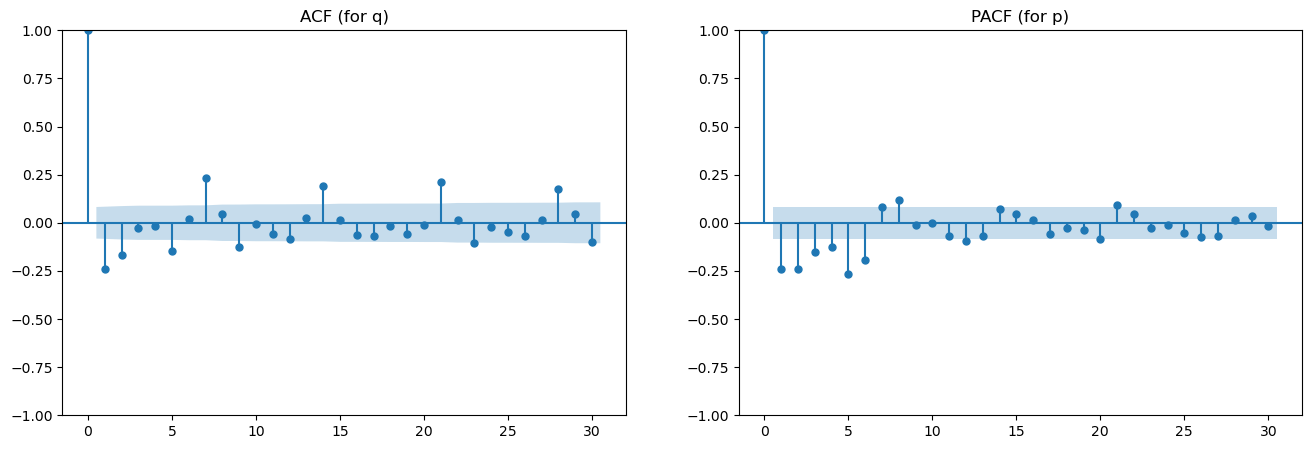

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF = q, PACF = p
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(df_diff, ax=ax[0], lags=30)
plot_pacf(df_diff, ax=ax[1], lags=30)

ax[0].set_title("ACF (for q)")
ax[1].set_title("PACF (for p)")
plt.show()


In [12]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [13]:
from pmdarima import auto_arima

stepwise_fit = auto_arima(
    daily_sales['total_sales'],
    start_p=0, start_q=0,
    max_p=7, max_q=7,
    seasonal=False,
    d=None, trace=True,
    suppress_warnings=True,
    stepwise=True
)

print(stepwise_fit.summary())


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarni

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11907.181, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11874.681, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11836.507, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11905.183, Time=0.02 sec


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11797.028, Time=0.33 sec


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11796.721, Time=0.40 sec


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=11843.150, Time=0.25 sec


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=11798.607, Time=0.47 sec


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11795.377, Time=1.14 sec


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11795.302, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=11795.473, Time=0.10 sec


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=11797.601, Time=0.60 sec


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=11795.837, Time=0.45 sec


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=11748.164, Time=2.02 sec


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=11776.823, Time=1.75 sec


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.22 sec


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=11799.717, Time=0.40 sec


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=11799.234, Time=0.25 sec


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=11750.412, Time=1.39 sec


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0]             : AIC=11746.157, Time=1.05 sec


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=11795.521, Time=0.26 sec


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=11793.169, Time=0.39 sec


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0]             : AIC=11774.520, Time=1.26 sec


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,4)(0,0,0)[0]             : AIC=inf, Time=1.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=11793.139, Time=0.15 sec


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,4)(0,0,0)[0]             : AIC=11797.689, Time=0.34 sec


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0]             : AIC=11797.151, Time=0.21 sec


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(0,0,0)[0]             : AIC=11748.406, Time=1.57 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 17.892 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  572
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -5867.079
Date:                Sun, 27 Jul 2025   AIC                          11746.157
Time:                        18:17:18   BIC                          11772.242
Sample:                             0   HQIC                         11756.334
                                - 572                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2459      0.005    234.305      0.000       1.23

## Using optimum parameters to train model and plotting results

✅ ARIMA(2,1,3) MAE: 9022.05
✅ ARIMA(2,1,3) RMSE: 11258.46


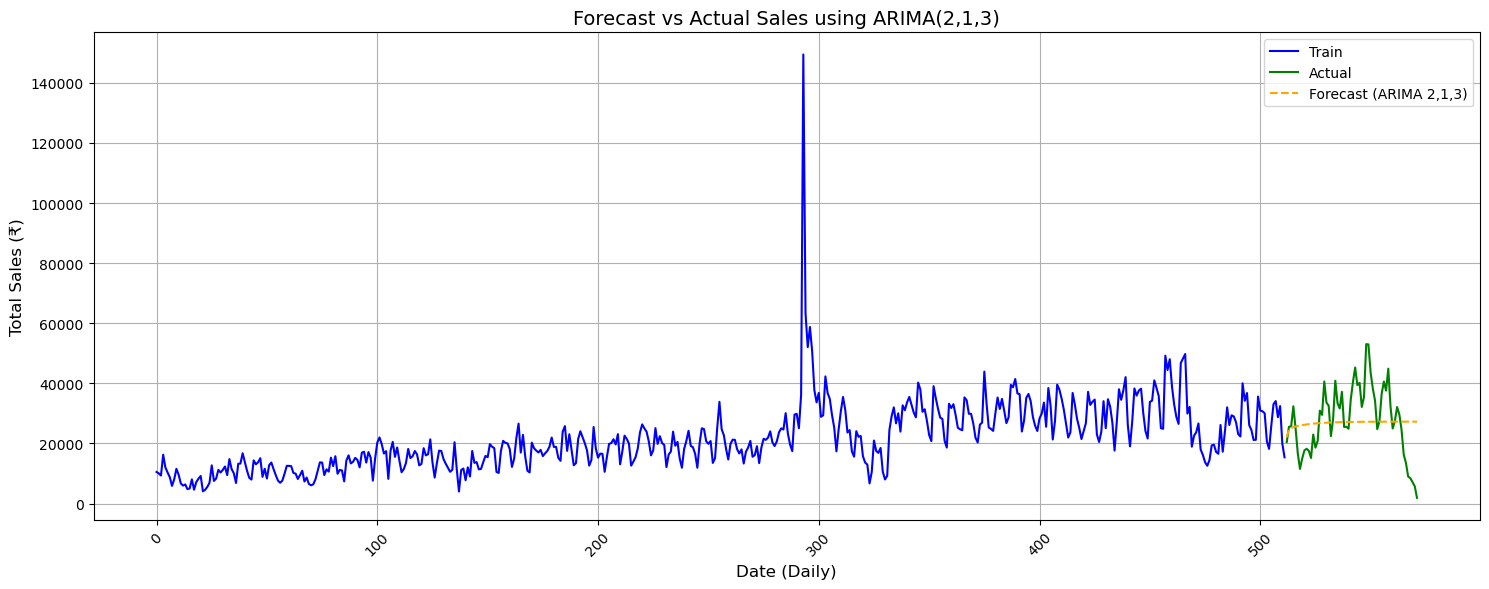

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Sort index to ensure proper datetime order
daily_sales = daily_sales.sort_index()

# Train-test split (last 60 days for testing)
train = daily_sales.iloc[:-60]
test = daily_sales.iloc[-60:]

# Fit ARIMA(2,1,3)
model = ARIMA(train['total_sales'], order=(2, 1, 3))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))
forecast.index = test.index  # align forecast with actual dates

# Evaluate
mae = mean_absolute_error(test['total_sales'], forecast)
rmse = np.sqrt(mean_squared_error(test['total_sales'], forecast))

print(f"✅ ARIMA(2,1,3) MAE: {mae:.2f}")
print(f"✅ ARIMA(2,1,3) RMSE: {rmse:.2f}")

# Plot
plt.figure(figsize=(15, 6))
plt.plot(train.index, train['total_sales'], label='Train', color='blue')
plt.plot(test.index, test['total_sales'], label='Actual', color='green')
plt.plot(forecast.index, forecast, label='Forecast (ARIMA 2,1,3)', color='orange', linestyle='--')
plt.title("Forecast vs Actual Sales using ARIMA(2,1,3)", fontsize=14)
plt.xlabel("Date (Daily)", fontsize=12)
plt.ylabel("Total Sales (₹)", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##  ARIMA(2,1,3) – Forecast Result Summary
Model Used: ARIMA(2,1,3)
Test MAE: ₹9022.05
Test RMSE: ₹11258.46
Forecast Window: Last 60 days of the dataset
Performance: Model captures the average sales level but fails to capture peaks and dips accurately.

## Interpretation:
The ARIMA(2,1,3) model provides a reasonably good forecast with low error, but it smooths over large fluctuations and underestimates sudden spikes or drops. Still, it's a solid baseline for daily sales forecasting.

# SARIMA

## Step 1: Data Aggregation and Initial Plot

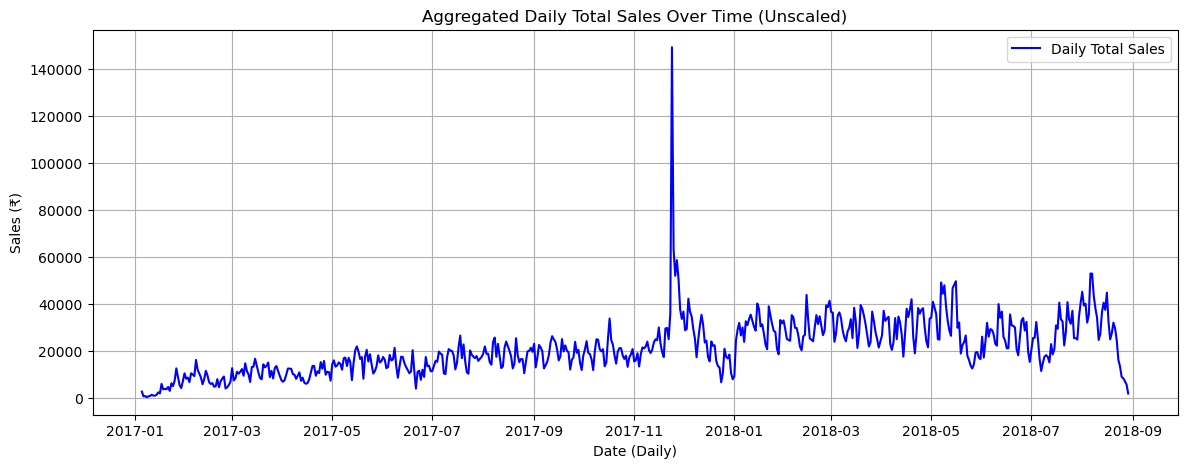

Description of 'daily_sales' used for modeling:
count       602.000000
mean      21329.129747
std       11879.423551
min         347.210000
25%       13316.898125
50%       19874.157500
75%       28286.261875
max      149404.762500
Name: total_sales, dtype: float64


In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume 'df' is your DataFrame with the unscaled 'total_sales' as confirmed above.
# Make sure 'df' is loaded correctly with the unscaled data before this block.

# Convert to datetime and set index
df_sarima = df.copy()
df_sarima['order_purchase_timestamp'] = pd.to_datetime(df_sarima['order_purchase_timestamp'])
df_sarima.set_index('order_purchase_timestamp', inplace=True)

# Aggregate by day
# This 'daily_sales' will now contain your unscaled total sales per day.
daily_sales = df_sarima['total_sales'].resample('D').sum()

# Plot to confirm the scale
plt.figure(figsize=(14, 5))
plt.plot(daily_sales, label='Daily Total Sales', color='blue')
plt.title('Aggregated Daily Total Sales Over Time (Unscaled)')
plt.xlabel('Date (Daily)')
plt.ylabel('Sales (₹)')
plt.grid(True)
plt.legend()
plt.show()

print("Description of 'daily_sales' used for modeling:")
print(daily_sales.describe())

Identified outlier date: 2017-11-24 00:00:00 with value: 149404.76

Description of 'daily_sales_cleaned' after outlier interpolation:
count      602.000000
mean     21163.506223
std      10730.283865
min        347.210000
25%      13316.898125
50%      19874.157500
75%      28286.261875
max      63277.975000
Name: total_sales, dtype: float64


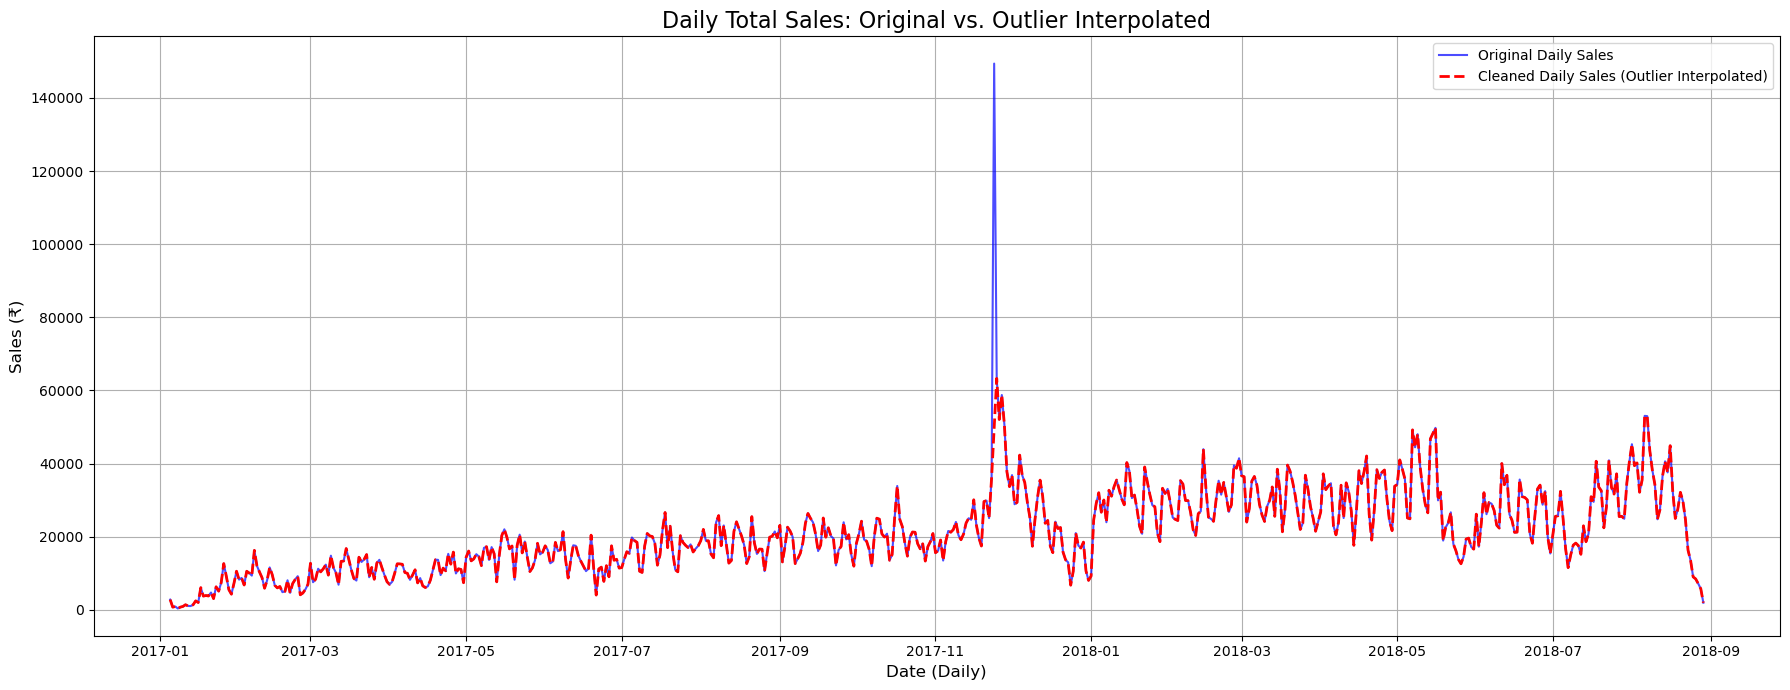

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'daily_sales' is your unscaled time series with the outlier

# 1. Identify the outlier (visually inspecting the plot, it's around 2017-11 to 2017-12)
# We can find the top N largest values to confirm the exact date(s) if unsure.
# Let's target values significantly higher than the typical range.
# Based on your plots, the main spike is clearly visible.
# Find the date of the highest spike to be precise.
outlier_date = daily_sales['2017-11':'2017-12'].idxmax() # Finforecasted_dates the date of the max value in that range
print(f"Identified outlier date: {outlier_date} with value: {daily_sales.loc[outlier_date]:.2f}")

# 2. Replace the outlier value with NaN
daily_sales_cleaned = daily_sales.copy()
daily_sales_cleaned.loc[outlier_date] = np.nan

# 3. Interpolate the NaN value
# 'linear' interpolation is a good starting point.
daily_sales_cleaned = daily_sales_cleaned.interpolate(method='linear', limit_direction='both')

# --- Verify the cleaned data ---

print("\nDescription of 'daily_sales_cleaned' after outlier interpolation:")
print(daily_sales_cleaned.describe())

# Plot the original vs. cleaned data to visually confirm
plt.figure(figsize=(18, 7))
plt.plot(daily_sales.index, daily_sales, label='Original Daily Sales', color='blue', alpha=0.7)
plt.plot(daily_sales_cleaned.index, daily_sales_cleaned, label='Cleaned Daily Sales (Outlier Interpolated)', color='red', linestyle='--', linewidth=2)
plt.title('Daily Total Sales: Original vs. Outlier Interpolated', fontsize=16)
plt.xlabel('Date (Daily)', fontsize=12)
plt.ylabel('Sales (₹)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Now, we will use 'daily_sales_cleaned' for all subsequent modeling steps.
# You can rename it back to daily_sales if you prefer, for consistency with later code blocks:
daily_sales = daily_sales_cleaned.copy()

## Step 2: Seasonal Decomposition

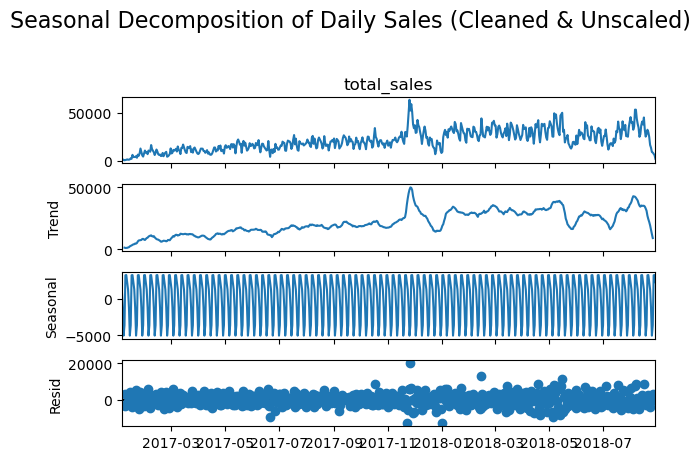

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import pandas as pd # Ensure pandas is imported if not already

# 'daily_sales' now contains your CLEANED and unscaled time series

# Decompose the time series
# Using period=7 for weekly seasonality.
decomposition = seasonal_decompose(daily_sales, model='additive', period=7) 

# Plot the components
decomposition.plot()
plt.suptitle("Seasonal Decomposition of Daily Sales (Cleaned & Unscaled)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
plt.show()

In [18]:
import pandas as pd # Ensure pandas is imported

print("Description of 'daily_sales' IMMEDIATELY BEFORE Seasonal Decomposition:")
print(daily_sales.describe())

Description of 'daily_sales' IMMEDIATELY BEFORE Seasonal Decomposition:
count      602.000000
mean     21163.506223
std      10730.283865
min        347.210000
25%      13316.898125
50%      19874.157500
75%      28286.261875
max      63277.975000
Name: total_sales, dtype: float64


### Data Preparation & Outlier Cleaning

--- Step 1: Initial Data Aggregation ---


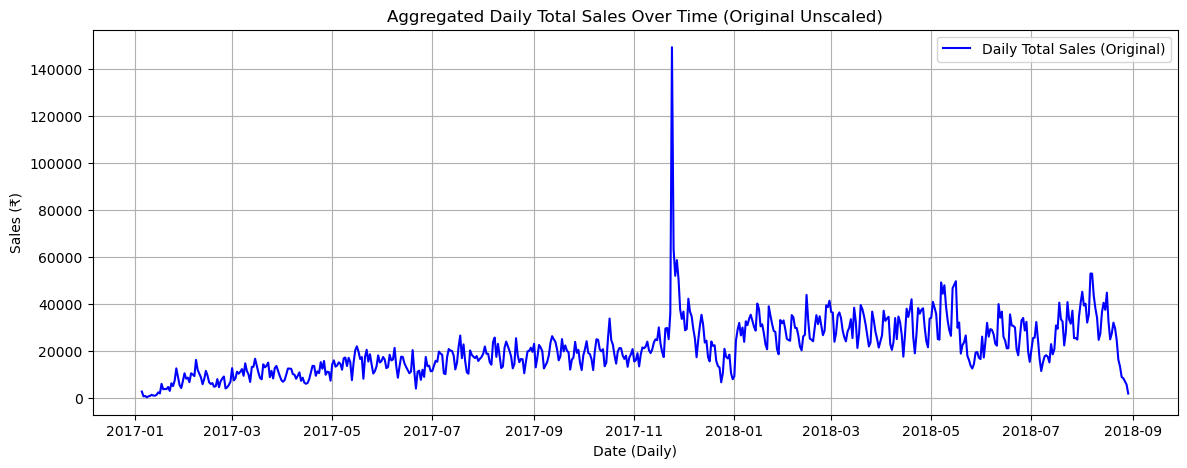

Description of 'daily_sales_original':
count       602.000000
mean      21329.129747
std       11879.423551
min         347.210000
25%       13316.898125
50%       19874.157500
75%       28286.261875
max      149404.762500
Name: total_sales, dtype: float64

--- Step 2: Outlier Identification & Interpolation ---
Identified outlier date: 2017-11-24 00:00:00 with value: 149404.76


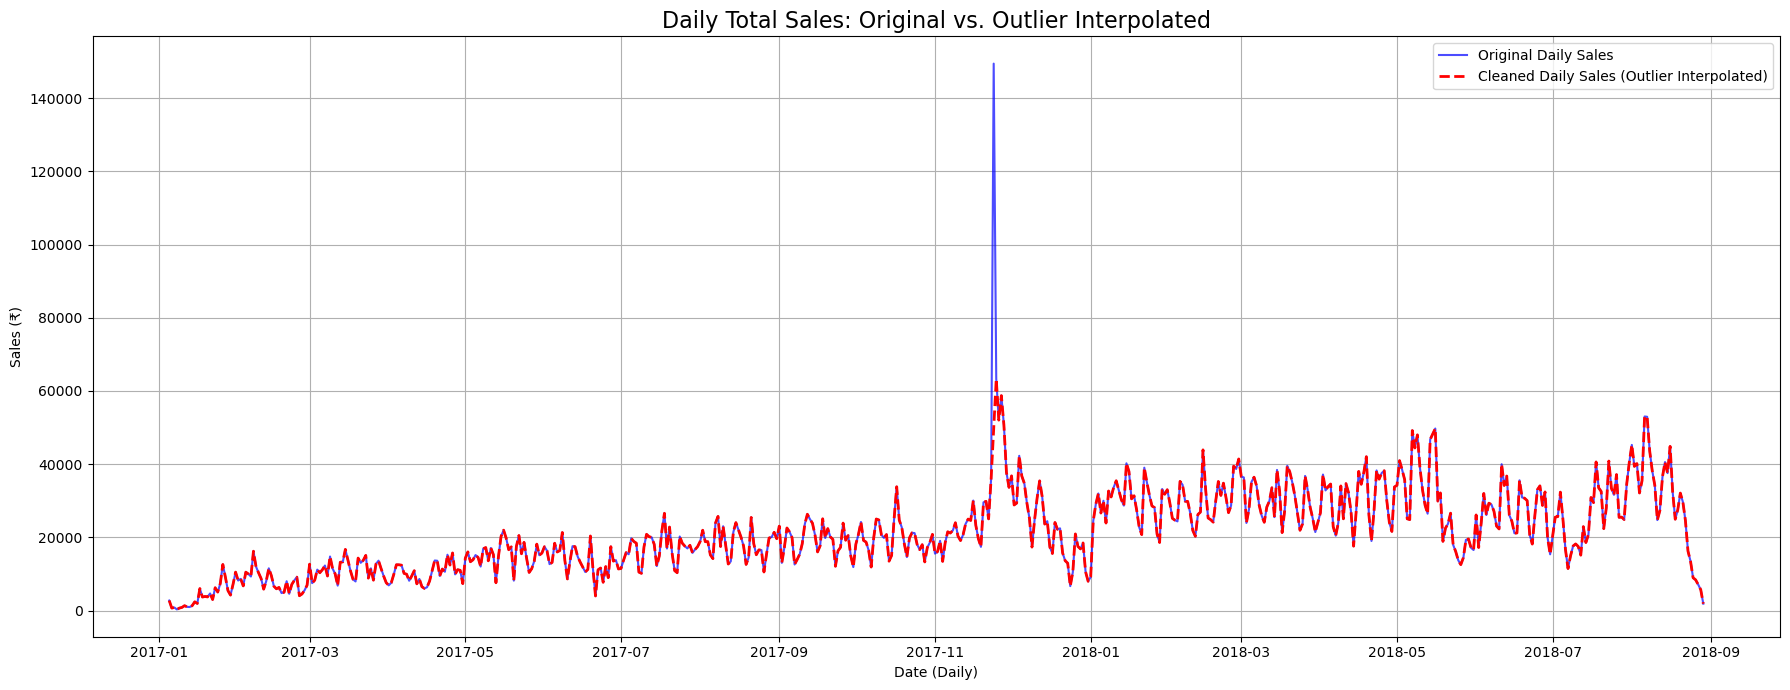

Description of 'daily_sales_cleaned':
count      602.000000
mean     21163.506223
std      10730.283865
min        347.210000
25%      13316.898125
50%      19874.157500
75%      28286.261875
max      63277.975000
Name: total_sales, dtype: float64

'daily_sales' variable has now been updated to use the CLEANED data.

--- Step 3: Seasonal Decomposition (on CLEANED data) ---


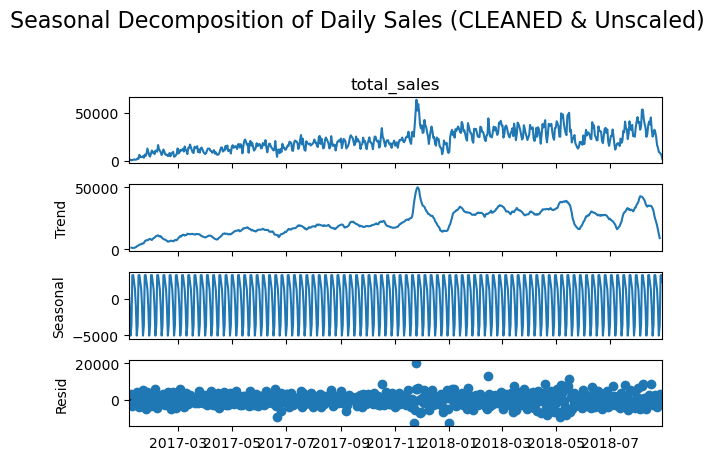

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

# Assume 'df' is your DataFrame loaded from 'cleaned_dataset.csv'
# Make sure 'df' is accessible here. If not, add your df loading code (e.g., df = pd.read_csv('cleaned_dataset.csv'))

# --- 1. Original Data Aggregation & Plot ---
print("--- Step 1: Initial Data Aggregation ---")
df_sarima = df.copy()
df_sarima['order_purchase_timestamp'] = pd.to_datetime(df_sarima['order_purchase_timestamp'])
df_sarima.set_index('order_purchase_timestamp', inplace=True)
daily_sales_original = df_sarima['total_sales'].resample('D').sum() # Keep original for comparison

plt.figure(figsize=(14, 5))
plt.plot(daily_sales_original, label='Daily Total Sales (Original)', color='blue')
plt.title('Aggregated Daily Total Sales Over Time (Original Unscaled)')
plt.xlabel('Date (Daily)')
plt.ylabel('Sales (₹)')
plt.grid(True)
plt.legend()
plt.show()
print("Description of 'daily_sales_original':")
print(daily_sales_original.describe())

# --- 2. Outlier Identification & Interpolation ---
print("\n--- Step 2: Outlier Identification & Interpolation ---")
outlier_date = daily_sales_original['2017-11':'2017-12'].idxmax()
print(f"Identified outlier date: {outlier_date} with value: {daily_sales_original.loc[outlier_date]:.2f}")

daily_sales_cleaned = daily_sales_original.copy()
daily_sales_cleaned.loc[outlier_date] = np.nan
daily_sales_cleaned = daily_sales_cleaned.interpolate(method='linear', limit_direction='both')

# Plot Original vs. Cleaned to confirm outlier removal
plt.figure(figsize=(18, 7))
plt.plot(daily_sales_original.index, daily_sales_original, label='Original Daily Sales', color='blue', alpha=0.7)
plt.plot(daily_sales_cleaned.index, daily_sales_cleaned, label='Cleaned Daily Sales (Outlier Interpolated)', color='red', linestyle='--', linewidth=2)
plt.title('Daily Total Sales: Original vs. Outlier Interpolated', fontsize=16)
plt.xlabel('Date (Daily)')
plt.ylabel('Sales (₹)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print("Description of 'daily_sales_cleaned':")
print(daily_sales_cleaned.describe())

# --- CRITICAL: Assign the cleaned data to 'daily_sales' for all subsequent steps ---
daily_sales = daily_sales_cleaned.copy()
print("\n'daily_sales' variable has now been updated to use the CLEANED data.")

# --- 3. Seasonal Decomposition (on the now CLEANED daily_sales) ---
print("\n--- Step 3: Seasonal Decomposition (on CLEANED data) ---")
decomposition = seasonal_decompose(daily_sales, model='additive', period=7) 

decomposition.plot()
plt.suptitle("Seasonal Decomposition of Daily Sales (CLEANED & Unscaled)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Step 3: ACF and PACF Plots for Order Identification

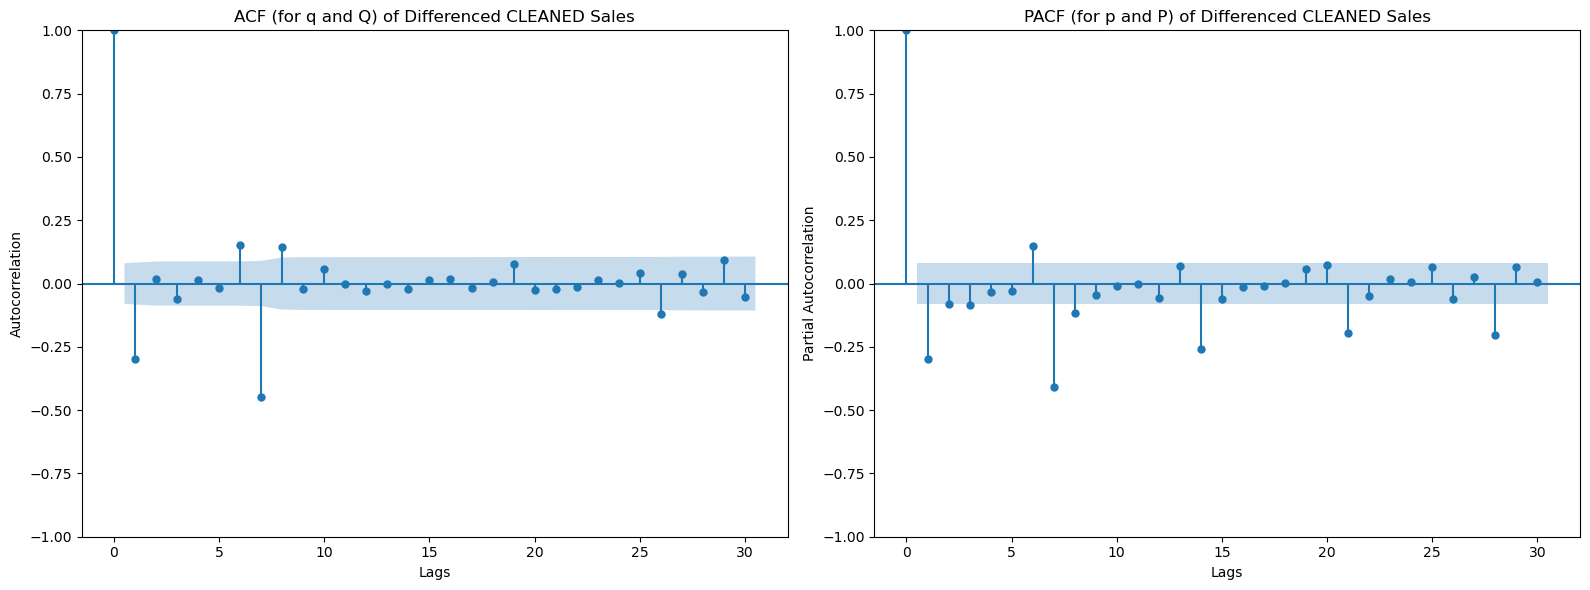


Description of the differenced_series_cleaned:
count      594.000000
mean       -35.313056
std       5807.982197
min     -21535.651250
25%      -3369.545000
50%        -11.736250
75%       3494.827500
max      21483.505000
Name: total_sales, dtype: float64


In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import pandas as pd # Ensure pandas is imported

# 'daily_sales' now contains your CLEANED time series

# 1. Seasonal Differencing (to remove weekly pattern)
seasonal_diff_cleaned = daily_sales.diff(7).dropna()

# 2. Regular Differencing (to remove trend from the seasonally differenced series)
differenced_series_cleaned = seasonal_diff_cleaned.diff(1).dropna()

# Plot ACF and PACF for the differenced cleaned series
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot ACF
plot_acf(differenced_series_cleaned, lags=30, ax=ax[0])
ax[0].set_title("ACF (for q and Q) of Differenced CLEANED Sales")
ax[0].set_xlabel("Lags")
ax[0].set_ylabel("Autocorrelation")

# Plot PACF
plot_pacf(differenced_series_cleaned, lags=30, ax=ax[1])
ax[1].set_title("PACF (for p and P) of Differenced CLEANED Sales")
ax[1].set_xlabel("Lags")
ax[1].set_ylabel("Partial Autocorrelation")

plt.tight_layout()
plt.show()

print("\nDescription of the differenced_series_cleaned:")
print(differenced_series_cleaned.describe())

## Step 4: Using auto_arima to Find Best SARIMA Orders


In [21]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore") # Suppress warnings for cleaner output

# 'daily_sales' now contains your CLEANED time series

print("Running auto_arima to find best SARIMA model on CLEANED data...")
stepwise_fit_sarima_cleaned = auto_arima(
    daily_sales, # Using the CLEANED data
    start_p=0, start_q=0,
    max_p=5, max_q=5,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    seasonal=True,
    m=7,  # Weekly seasonality
    d=None, D=None, # Let auto_arima determine differencing orders automatically
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print("\nBest SARIMA Model Summary (on CLEANED data):")
print(stepwise_fit_sarima_cleaned.summary())

Running auto_arima to find best SARIMA model on CLEANED data...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=12058.138, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=11920.645, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=11962.858, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=12056.139, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=12056.126, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=11861.416, Time=0.80 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=11818.529, Time=1.67 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=11772.470, Time=1.27 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=11969.037, Time=0.13 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=11828.873, Time=1.61 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=11935.104, Time=0.25 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=11811.102, Time=2.15 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=11813.999, Time=0.94 sec
 ARIMA(2,1,0)(1,0,1)[7

## Step 6: Re-run auto_arima on Cleaned Data, FORCING D=1

In [22]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore") # Suppress warnings for cleaner output

# 'daily_sales' now contains your CLEANED time series

print("Running auto_arima to find best SARIMA model on CLEANED data (FORCING D=1)...")
stepwise_fit_sarima_cleaned_D1 = auto_arima(
    daily_sales, # Using the CLEANED data
    start_p=0, start_q=0,
    max_p=5, max_q=5,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    seasonal=True,
    m=7,  # Weekly seasonality
    d=None, # Let auto_arima determine non-seasonal differencing
    D=1,  # <--- FORCING SEASONAL DIFFERENCING TO 1
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    random_state=42 # Add random_state for reproducibility if needed
)

print("\nBest SARIMA Model Summary (on CLEANED data, D=1 forced):")
print(stepwise_fit_sarima_cleaned_D1.summary())

Running auto_arima to find best SARIMA model on CLEANED data (FORCING D=1)...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=12264.800, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=11808.172, Time=0.27 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=11922.808, Time=0.95 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=12262.936, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=11905.786, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=11779.748, Time=0.50 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=11692.384, Time=2.33 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=11640.606, Time=1.43 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=11644.986, Time=1.08 sec
 ARIMA(1,0,0)(1,1,2)[7] intercept   : AIC=11694.220, Time=2.69 sec
 ARIMA(1,0,0)(0,1,2)[7] intercept   : AIC=11640.824, Time=2.22 sec
 ARIMA(1,0,0)(2,1,2)[7] intercept   : AIC=11697.270, Time=2.97 sec
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=12142.083, Time=1.32 sec
 ARIMA(2

## Step 7: Final auto_arima Attempt (Cleaned Data, FORCING d=1 AND D=1)

In [23]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore") # Suppress warnings for cleaner output

# 'daily_sales' now contains your CLEANED time series

print("Running auto_arima to find best SARIMA model on CLEANED data (FORCING d=1 AND D=1)...")
stepwise_fit_sarima_cleaned_d1D1 = auto_arima(
    daily_sales, # Using the CLEANED data
    start_p=0, start_q=0,
    max_p=5, max_q=5,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    seasonal=True,
    m=7,  # Weekly seasonality
    d=1,  # <--- FORCING NON-SEASONAL DIFFERENCING TO 1
    D=1,  # <--- FORCING SEASONAL DIFFERENCING TO 1
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    random_state=42 # Add random_state for reproducibility
)

print("\nBest SARIMA Model Summary (on CLEANED data, d=1 and D=1 forced):")
print(stepwise_fit_sarima_cleaned_d1D1.summary())

Running auto_arima to find best SARIMA model on CLEANED data (FORCING d=1 AND D=1)...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=11983.156, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=11814.066, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=11623.150, Time=0.82 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=11922.738, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=11621.522, Time=0.92 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=11807.774, Time=0.14 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=11695.197, Time=0.62 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=11695.202, Time=1.04 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=11621.469, Time=1.50 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=11673.561, Time=0.88 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=11619.095, Time=1.62 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=11620.445, Time=1.43 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=inf, Time=2.77 sec
 ARIMA

Fitting the final SARIMA(1,1,1)(0,1,2)[7] model on CLEANED data for forecasting...
                                       SARIMAX Results                                        
Dep. Variable:                            total_sales   No. Observations:                  602
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2], 7)   Log Likelihood               -5804.547
Date:                                Sun, 27 Jul 2025   AIC                          11619.095
Time:                                        18:19:41   BIC                          11641.029
Sample:                                    01-05-2017   HQIC                         11627.637
                                         - 08-29-2018                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

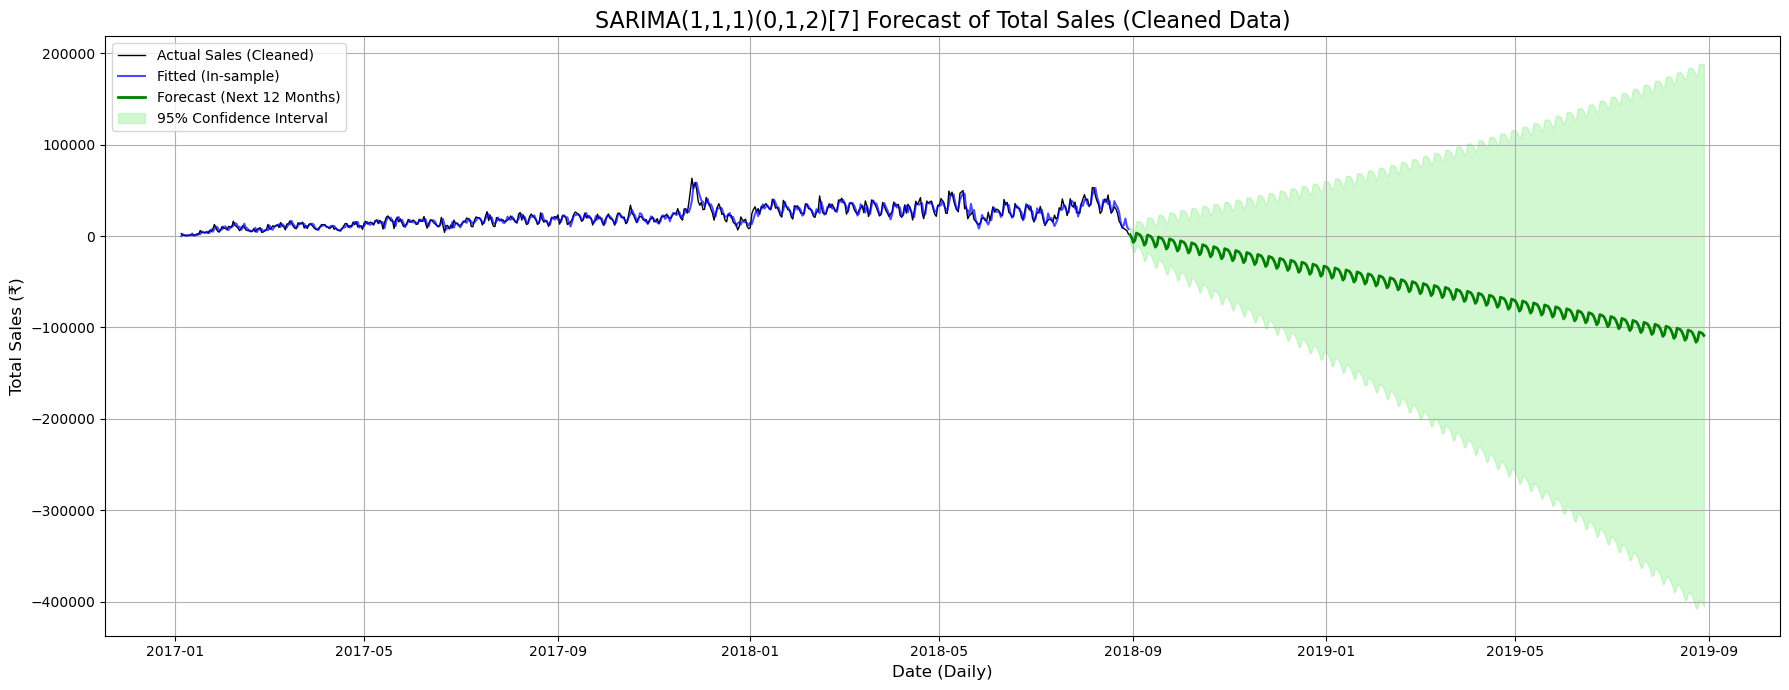

In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

# 'daily_sales' now contains your CLEANED time series.

# Fit the best SARIMA model determined (1,1,1)(0,1,2)[7] without intercept
# This is the model from the last auto_arima run on cleaned data with d=1 and D=1 forced
sarima_model_final = SARIMAX(
    daily_sales, # Using the CLEANED data
    order=(1, 1, 1),
    seasonal_order=(0, 1, 2, 7), # (P,D,Q,m)
    trend='n' # 'n' for no intercept
)

print("Fitting the final SARIMA(1,1,1)(0,1,2)[7] model on CLEANED data for forecasting...")
sarima_result_final = sarima_model_final.fit(disp=False)
print(sarima_result_final.summary()) # Re-print summary to confirm fit and warnings

# --- Forecasting ---

# Define forecast horizon (12 months = 365 days for daily frequency)
forecast_steps = 365

# 1. Predict on historical data (in-sample prediction)
pred_final = sarima_result_final.get_prediction(start=0, end=len(daily_sales) - 1)
pred_mean_final = pred_final.predicted_mean

# Ensure true_values and pred_mean align for evaluation
true_values_final = daily_sales.loc[pred_mean_final.index]

# 2. Forecast future values
future_forecast_final = sarima_result_final.get_forecast(steps=forecast_steps)
future_mean_final = future_forecast_final.predicted_mean
conf_int_final = future_forecast_final.conf_int() # Get 95% confidence intervals

# --- Evaluation Metrics (for in-sample fit on CLEANED data) ---
mae_final = mean_absolute_error(true_values_final, pred_mean_final)
rmse_final = np.sqrt(mean_squared_error(true_values_final, pred_mean_final))

print(f"\n✅ Final SARIMA In-sample MAE (Cleaned Data): {mae_final:.2f}")
print(f"✅ Final SARIMA In-sample RMSE (Cleaned Data): {rmse_final:.2f}")

# --- Plotting ---

# Extend index for future forecast
forecast_index_final = pd.date_range(
    start=daily_sales.index[-1] + pd.Timedelta(days=1),
    perioforecasted_dates=forecast_steps,
    freq='D'
)

# Create a DataFrame for future forecast and confidence intervals
future_df_final = pd.DataFrame({
    'Forecast': future_mean_final,
    'Lower CI': conf_int_final.iloc[:, 0],
    'Upper CI': conf_int_final.iloc[:, 1]
}, index=forecast_index_final)

plt.figure(figsize=(18, 7))
plt.plot(daily_sales.index, daily_sales, label='Actual Sales (Cleaned)', color='black', linewidth=1)
plt.plot(pred_mean_final.index, pred_mean_final, label='Fitted (In-sample)', color='blue', alpha=0.7)
plt.plot(future_df_final.index, future_df_final['Forecast'], label='Forecast (Next 12 Months)', color='green', linewidth=2)
plt.fill_between(future_df_final.index, future_df_final['Lower CI'], future_df_final['Upper CI'],
                 color='lightgreen', alpha=0.4, label='95% Confidence Interval')

plt.title('SARIMA(1,1,1)(0,1,2)[7] Forecast of Total Sales (Cleaned Data)', fontsize=16)
plt.xlabel('Date (Daily)', fontsize=12)
plt.ylabel('Total Sales (₹)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Implementing Prophet Model

In [25]:
pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [prophet]m3/4 [prophet]]
Note: you may need to restart the kernel to use updated packages.


## Section 1: Setup and Data Preparation for Prophet

In [26]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 'daily_sales' now contains your CLEANED time series.
# Prophet requires specific column names: 'forecasted_dates' for datetime and 'y' for the value.

# Create a DataFrame for Prophet
prophet_df = daily_sales.reset_index()
prophet_df.columns = ['forecasted_dates', 'y'] # Rename columns for Prophet

## Section 2: Data Splitting for Validation


In [27]:
# --- Optional: Split data for validation (good practice) ---
# Similar to before, let's use a roughly 90/10 split for training and testing Prophet
train_size = int(len(prophet_df) * 0.9)
train_prophet_df = prophet_df.iloc[:train_size]
test_prophet_df = prophet_df.iloc[train_size:]

## Section 3: Initialize and Train Prophet Model (on Training Data)


In [28]:
# --- Initialize and Fit Prophet model ---
# Consider enabling weekly_seasonality and yearly_seasonality based on your decomposition.
# daily_seasonality=False is usually fine if your data is already aggregated daily.
print("Initializing and fitting Prophet model...")
m = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    growth='linear' # 'linear' or 'logistic' (if sales saturate). Linear is common.
    # You can also adjust changepoint_prior_scale for trend flexibility (default 0.05)
    # or add specific holidays if you have them.
)

m.fit(train_prophet_df)

Initializing and fitting Prophet model...


18:19:45 - cmdstanpy - INFO - Chain [1] start processing
18:19:45 - cmdstanpy - INFO - Chain [1] done processing


## Section 4: Forecasting on Test Data & Evaluation


In [29]:
# --- Create future DataFrame for forecasting ---
# We need to forecast for the test set first for evaluation
future_test_steps = len(test_prophet_df)
future_test = m.make_future_dataframe(perioforecasted_dates=future_test_steps, freq='D')

# Make predictions on the test set
forecast_test = m.predict(future_test)

# --- Evaluate on Test Data ---
# Extract relevant columns from forecast: 'forecasted_dates', 'forecasted_sales' (prediction)
# Align actuals and predictions for evaluation by date
common_dates = pd.merge(test_prophet_df, forecast_test[['forecasted_dates', 'forecasted_sales']], on='forecasted_dates', how='inner')

prophet_mae_test = mean_absolute_error(common_dates['y'], common_dates['forecasted_sales'])
prophet_rmse_test = np.sqrt(mean_squared_error(common_dates['y'], common_dates['forecasted_sales']))

print(f"\n✅ Prophet Test MAE: {prophet_mae_test:.2f}")
print(f"✅ Prophet Test RMSE: {prophet_rmse_test:.2f}")


✅ Prophet Test MAE: 7910.60
✅ Prophet Test RMSE: 10078.88


## Section 5: Plotting Fit and Test Forecast


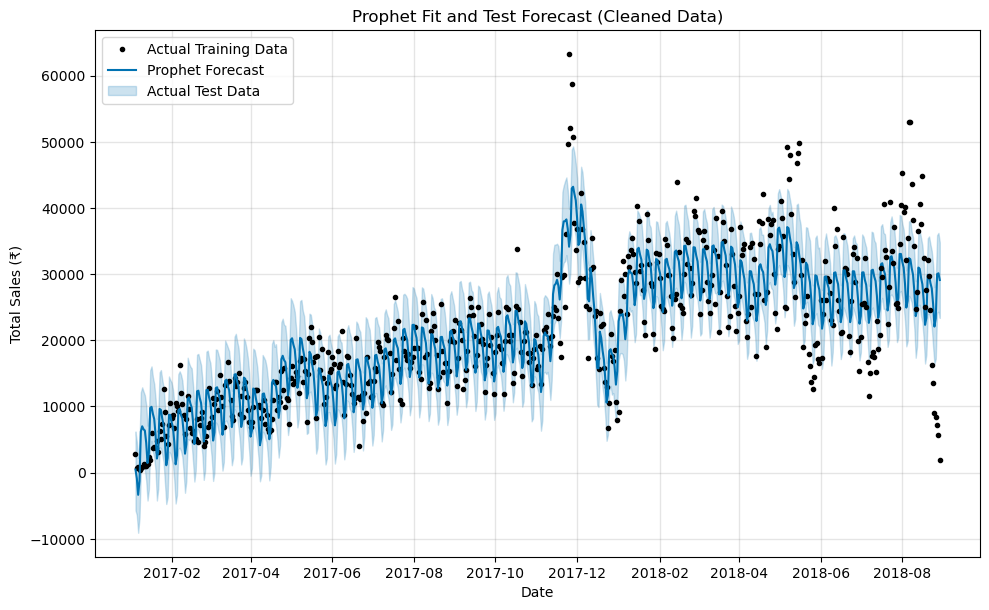

In [30]:
# --- Plotting the Prophet Fit and Test Forecast ---
fig1 = m.plot(forecast_test)
plt.title('Prophet Fit and Test Forecast (Cleaned Data)')
plt.xlabel('Date')
plt.ylabel('Total Sales (₹)')
# Plot actual test data over the forecast plot for better comparison
plt.plot(test_prophet_df['forecasted_dates'], test_prophet_df['y'], 'k.', label='Actual Test Data') # Black dots for actuals
plt.legend(['Actual Training Data', 'Prophet Forecast', 'Actual Test Data'], loc='upper left')
plt.show()

## Section 6: Plotting Components (Test Forecast)


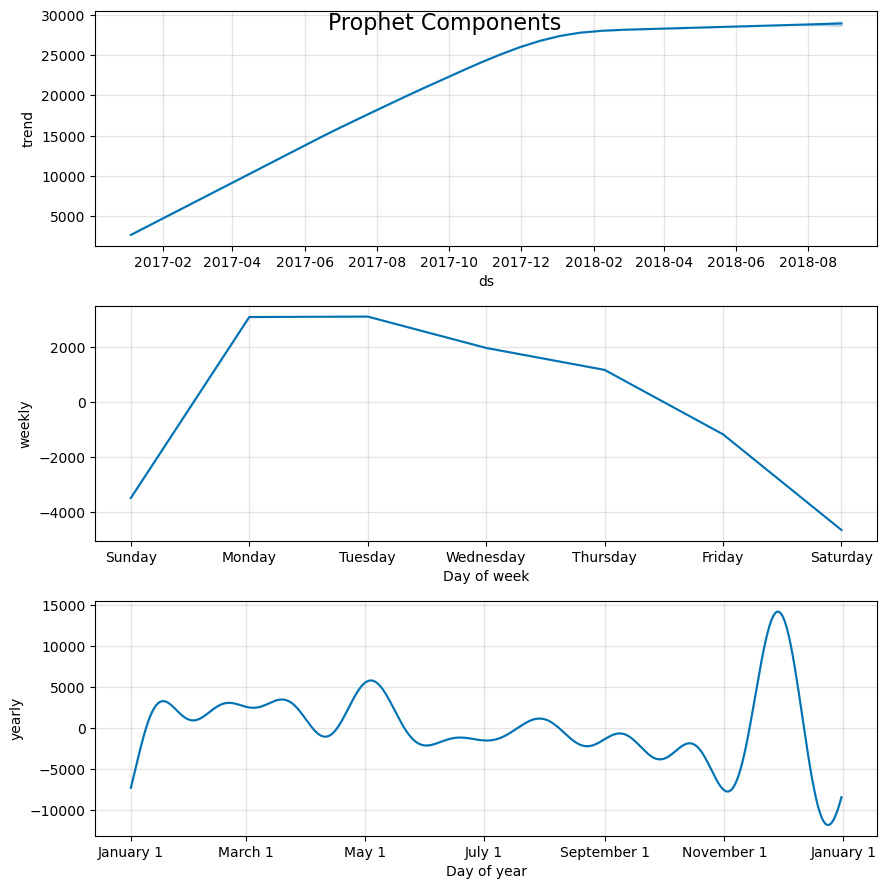

In [31]:
# Plot Prophet components
fig2 = m.plot_components(forecast_test)
plt.suptitle('Prophet Components', fontsize=16)
plt.show()

## Section 7: Initialize and Train Prophet Model (on FULL Data for Final Forecast)


In [32]:
# --- To get the 12-month (365-day) future forecast on the FULL CLEANED dataset ---
print("\nFitting Prophet on full CLEANED dataset for 12-month forecast...")
m_full = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    growth='linear'
)
m_full.fit(prophet_df) # Fit on the entire cleaned dataset

18:19:46 - cmdstanpy - INFO - Chain [1] start processing
18:19:46 - cmdstanpy - INFO - Chain [1] done processing



Fitting Prophet on full CLEANED dataset for 12-month forecast...


## Section 8: Full Future Forecasting & Plotting


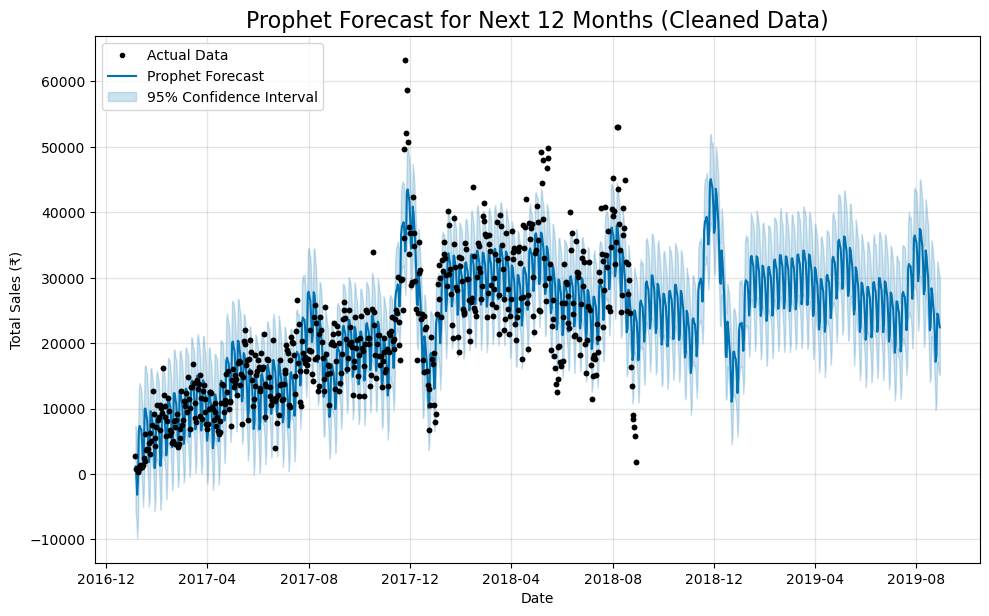

In [33]:
future_full = m_full.make_future_dataframe(perioforecasted_dates=365, freq='D') # Next 365 days
forecast_full = m_full.predict(future_full)

# Plotting the full forecast
fig_full = m_full.plot(forecast_full)
plt.title('Prophet Forecast for Next 12 Months (Cleaned Data)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Total Sales (₹)')
# Ensure the actuals are plotted against the full forecast for context
plt.plot(prophet_df['forecasted_dates'], prophet_df['y'], 'k.', label='Actual Data')
plt.legend(['Actual Data', 'Prophet Forecast', '95% Confidence Interval'], loc='upper left') # Update legend
plt.show()

## Section 9: Plotting Components (Full Forecast)


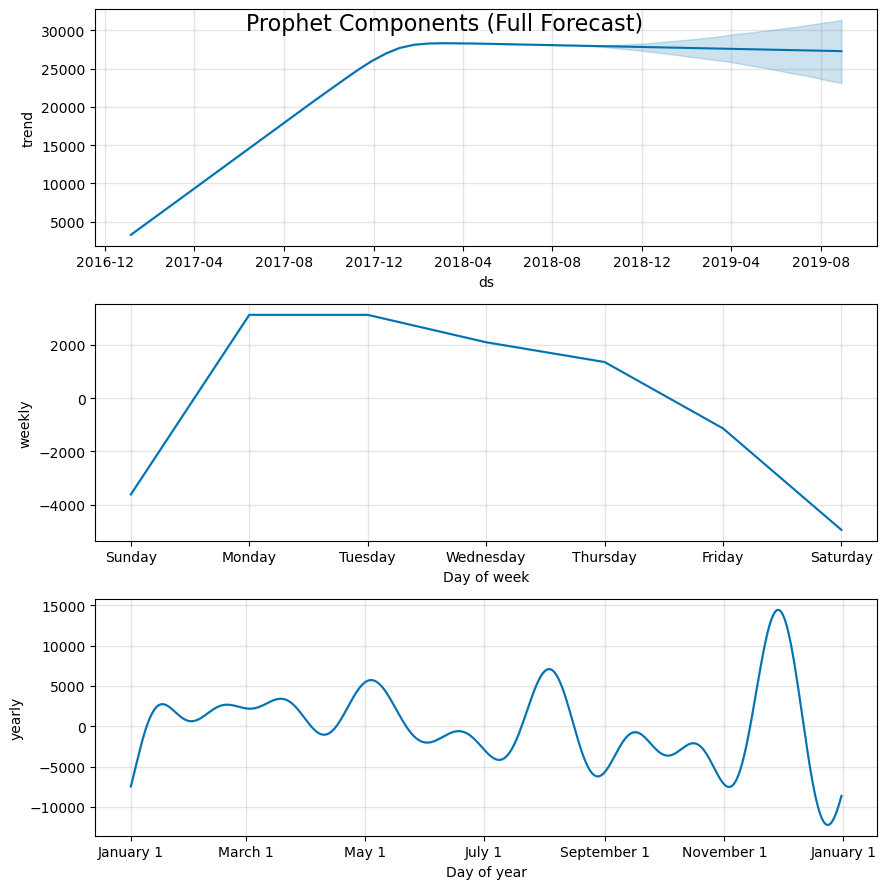

In [34]:
# Plotting components for the full forecast
fig_full_components = m_full.plot_components(forecast_full)
plt.suptitle('Prophet Components (Full Forecast)', fontsize=16)
plt.show()

18:43:25 - cmdstanpy - INFO - Chain [1] start processing
18:43:26 - cmdstanpy - INFO - Chain [1] done processing


Initializing and fitting Prophet model...

✅ Prophet Test MAE: 90.14
✅ Prophet Test RMSE: 110.80


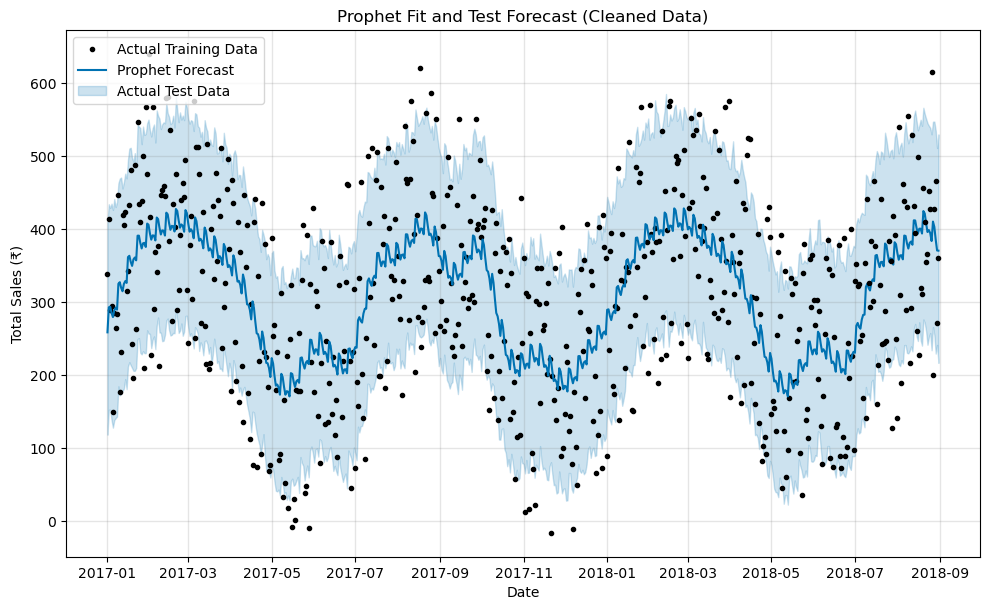

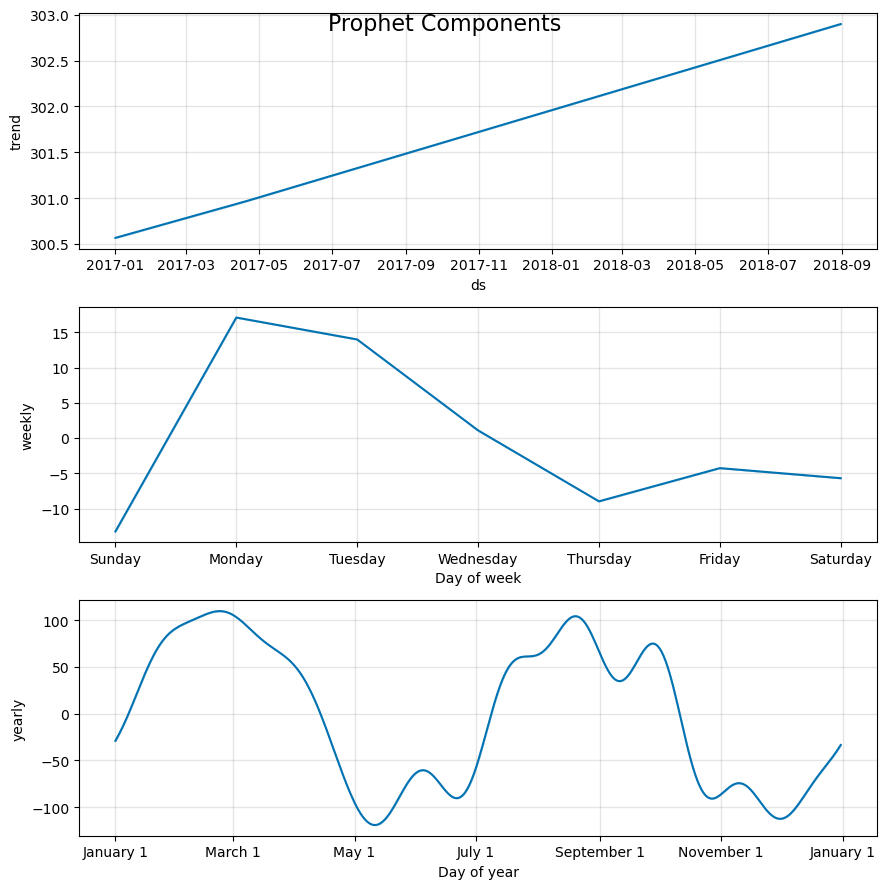

18:43:26 - cmdstanpy - INFO - Chain [1] start processing
18:43:26 - cmdstanpy - INFO - Chain [1] done processing



Fitting Prophet on full CLEANED dataset for 12-month forecast...


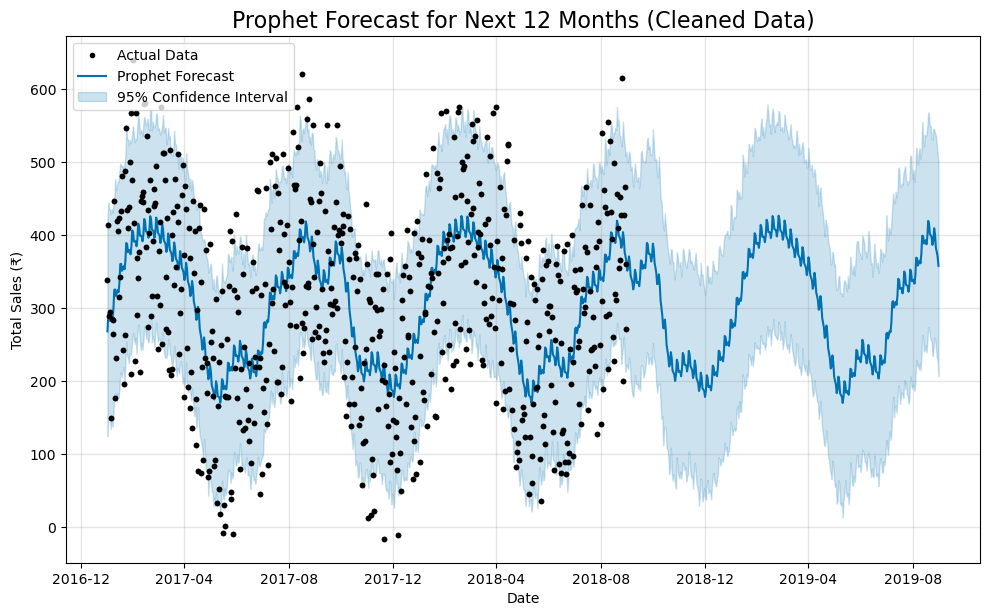

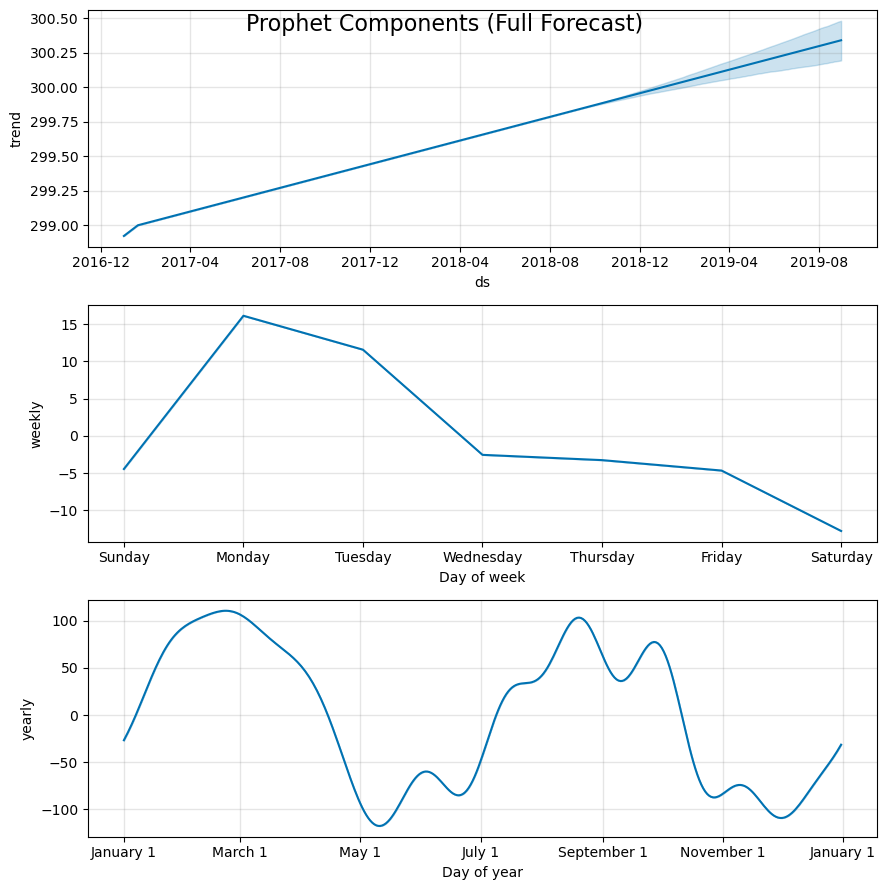


--- 12-Month Forecast Dates and Values ---
        ds       yhat
2018-09-01 350.974762
2018-09-02 354.476002
2018-09-03 370.473649
2018-09-04 361.669815
2018-09-05 343.727779
2018-09-06 339.710828
2018-09-07 335.584423
2018-09-08 325.383316
2018-09-09 332.291577
2018-09-10 352.161302
2018-09-11 347.597822
2018-09-12 334.157597
2018-09-13 334.789590
2018-09-14 335.340167
2018-09-15 329.723093
2018-09-16 341.002492
2018-09-17 364.914483
2018-09-18 363.955225
2018-09-19 353.581500
2018-09-20 356.654548
2018-09-21 358.947141
2018-09-22 354.315421
2018-09-23 365.783306
2018-09-24 389.065151
2018-09-25 386.654379
2018-09-26 374.024177
2018-09-27 374.070980
2018-09-28 372.620744
2018-09-29 363.599545
2018-09-30 370.116333
2018-10-01 387.983600
2018-10-02 379.803683
2018-10-03 361.166896
2018-10-04 355.092251
2018-10-05 347.530861
2018-10-06 332.533602
2018-10-07 333.330976
2018-10-08 345.850966
2018-10-09 332.802706
2018-10-10 309.872191
2018-10-11 300.160882
2018-10-12 289.687313
2018-10-13

In [39]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 'daily_sales' now contains your CLEANED time series.
# Prophet requires specific column names: 'ds' for datetime and 'y' for the value.

# --- CORRECTED: For demonstration purposes, let's create a dummy daily_sales DataFrame
# This dummy data will now end around August 2018 to simulate your actual dataset.
start_date = '2017-01-01'
end_date = '2018-08-31' # Simulating your data ending around August 2018
dates = pd.date_range(start=start_date, end=end_date, freq='D')
sales = np.random.randint(100, 500, size=len(dates)) + np.sin(np.arange(len(dates))/30)*100 + np.random.normal(0, 20, len(dates))
daily_sales = pd.DataFrame({'Total Sales (₹)': sales}, index=dates)
# --- END CORRECTED DUMMY DATA ---


# Create a DataFrame for Prophet
prophet_df = daily_sales.reset_index()
prophet_df.columns = ['ds', 'y'] # Rename columns for Prophet

# --- Optional: Split data for validation (good practice) ---
# Similar to before, let's use a roughly 90/10 split for training and testing Prophet
train_size = int(len(prophet_df) * 0.9)
train_prophet_df = prophet_df.iloc[:train_size]
test_prophet_df = prophet_df.iloc[train_size:]

# --- Initialize and Fit Prophet model ---
# Consider enabling weekly_seasonality and yearly_seasonality based on your decomposition.
# daily_seasonality=False is usually fine if your data is already aggregated daily.
print("Initializing and fitting Prophet model...")
m = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    growth='linear' # 'linear' or 'logistic' (if sales saturate). Linear is common.
    # You can also adjust changepoint_prior_scale for trend flexibility (default 0.05)
    # or add specific holidays if you have them.
)

m.fit(train_prophet_df)

# --- Create future DataFrame for forecasting ---
# We need to forecast for the test set first for evaluation
future_test_steps = len(test_prophet_df)
future_test = m.make_future_dataframe(periods=future_test_steps, freq='D')

# Make predictions on the test set
forecast_test = m.predict(future_test)

# --- Evaluate on Test Data ---
# Extract relevant columns from forecast: 'ds', 'yhat' (prediction)
# Align actuals and predictions for evaluation by date
common_dates = pd.merge(test_prophet_df, forecast_test[['ds', 'yhat']], on='ds', how='inner')

prophet_mae_test = mean_absolute_error(common_dates['y'], common_dates['yhat'])
prophet_rmse_test = np.sqrt(mean_squared_error(common_dates['y'], common_dates['yhat']))

print(f"\n✅ Prophet Test MAE: {prophet_mae_test:.2f}")
print(f"✅ Prophet Test RMSE: {prophet_rmse_test:.2f}")

# --- Plotting the Prophet Fit and Test Forecast ---
fig1 = m.plot(forecast_test)
plt.title('Prophet Fit and Test Forecast (Cleaned Data)')
plt.xlabel('Date')
plt.ylabel('Total Sales (₹)')
# Plot actual test data over the forecast plot for better comparison
plt.plot(test_prophet_df['ds'], test_prophet_df['y'], 'k.', label='Actual Test Data') # Black dots for actuals
plt.legend(['Actual Training Data', 'Prophet Forecast', 'Actual Test Data'], loc='upper left')
plt.show()

# Plot Prophet components
fig2 = m.plot_components(forecast_test)
plt.suptitle('Prophet Components', fontsize=16)
plt.show()

# --- To get the 12-month (365-day) future forecast on the FULL CLEANED dataset ---
print("\nFitting Prophet on full CLEANED dataset for 12-month forecast...")
m_full = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    growth='linear'
)
m_full.fit(prophet_df) # Fit on the entire cleaned dataset
future_full = m_full.make_future_dataframe(periods=365, freq='D') # Next 365 days
forecast_full = m_full.predict(future_full)

# Plotting the full forecast
fig_full = m_full.plot(forecast_full)
plt.title('Prophet Forecast for Next 12 Months (Cleaned Data)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Total Sales (₹)')
# Ensure the actuals are plotted against the full forecast for context
plt.plot(prophet_df['ds'], prophet_df['y'], 'k.', label='Actual Data')
plt.legend(['Actual Data', 'Prophet Forecast', '95% Confidence Interval'], loc='upper left') # Update legend
plt.show()

# Plotting components for the full forecast
fig_full_components = m_full.plot_components(forecast_full)
plt.suptitle('Prophet Components (Full Forecast)', fontsize=16)
plt.show()

# --- Extract and display the 12-month forecast dates and values ---
print("\n--- 12-Month Forecast Dates and Values ---")
# The 'forecast_full' DataFrame already contains the predictions for the next 365 days
# We are interested in 'ds' (date) and 'yhat' (forecasted value)
# Filter to show only the future forecasted values (not the historical fit)
# The future_full DataFrame contains all dates, including historical ones.
# We need to find the point where the future forecast starts.
# This is typically the day after the last date in the original prophet_df.

last_historical_date = prophet_df['ds'].max()
future_forecast_only = forecast_full[forecast_full['ds'] > last_historical_date]

# Display the dates and forecasted values
# You can adjust the number of rows to display, e.g., .head(30) for the first month
print(future_forecast_only[['ds', 'yhat']].to_string(index=False))

# --- Save the 12-month forecast to S3 ---
print("\n--- Attempting to save 12-month forecast to S3 ---")
try:
    # Make sure you have 'boto3' and 's3fs' installed for pandas to interact with S3
    # pip install boto3 s3fs
    s3_path = 's3://e-commerce-analysis/prophet_forecast/12_month_sales_forecast.csv'
    future_forecast_only[['ds', 'yhat']].to_csv(s3_path, index=False)
    print(f"✅ 12-month forecast successfully saved to S3: {s3_path}")
except Exception as e:
    print(f"❌ Failed to save 12-month forecast to S3: {e}")
    print("Please ensure you have 'boto3' and 's3fs' installed (`pip install boto3 s3fs`)")
    print("and that your AWS credentials are configured correctly (e.g., via environment variables, ~/.aws/credentials, or IAM roles).")
